<a href="https://colab.research.google.com/github/Ashwin1234/CS-521-Project/blob/master/CS521Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import numpy as np
import re
import string
import tensorflow as tf
from datasets import load_dataset
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.svm import SVC
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.models import model_from_json
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import plot_confusion_matrix
import keras

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!pip install datasets

     |████████████████████████████████| 325 kB 19.0 MB/s 
     |████████████████████████████████| 136 kB 52.7 MB/s 
     |████████████████████████████████| 212 kB 47.6 MB/s 
     |████████████████████████████████| 1.1 MB 50.6 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 127 kB 59.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 52.4 MB/s 
     |████████████████████████████████| 144 kB 54.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 27.1 MB/s 
     |████████████████████████████████| 6.6 MB 39.7 MB/s 
     |████████████████████████████████| 895 kB 9.6 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset = load_dataset("liar")


Using custom data configuration default


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
dataset_train = pd.DataFrame(dataset['train'])
dataset_test = pd.DataFrame(dataset['test'])
dataset_validate = pd.DataFrame(dataset['validation'])

In [11]:
dataset_train.size

143766

In [12]:
dataset_train.describe()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000
mean,2.136722,11.560132,13.313857,17.195637,16.490505,6.202746
std,1.585507,19.006447,24.140583,35.948211,36.251253,16.117701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000
75%,3.000000,12.000000,15.000000,13.000000,11.000000,5.000000
max,5.000000,70.000000,114.000000,160.000000,163.000000,105.000000


In [13]:
dataset_train.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [14]:
dataset_train['label'].value_counts()

1    2123
0    1998
2    1966
3    1683
4    1657
5     842
Name: label, dtype: int64

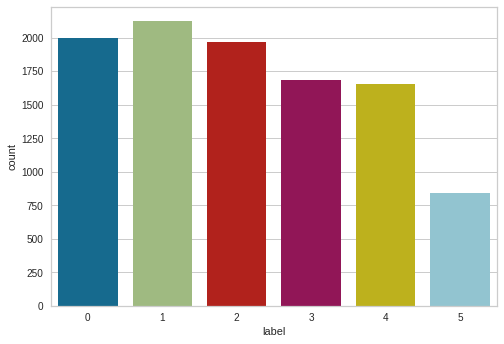

In [15]:
sns.countplot(x = 'label', data = dataset_train)

KeyboardInterrupt: ignored

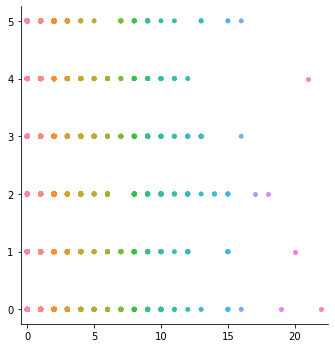

In [19]:
sns.catplot(x='party_affiliation', y='label', kind = 'swarm', data = dataset_train)

In [166]:
class_names = ['0','1','2','3','4','5']

In [109]:

dataset_train['statement'] = dataset_train.apply(lambda row : row['statement'].lower(), axis = 1)


In [101]:
dataset_train['statement'] = dataset_train['statement'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

TypeError: ignored

In [110]:
# Removing stop words
dataset_train['statement'] = dataset_train.apply(lambda row: remove_stopwords(row['statement']),axis = 1)

In [111]:
#Tokenization

dataset_train['statement'] = dataset_train.apply(lambda row : list(tokenize(row['statement'])), axis = 1)

In [112]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
dataset_train['comment'] = dataset_train.apply(lambda row : list(lemmatizer.lemmatize(word) for word in row['statement']),axis = 1)

In [19]:
dataset_train['statement'] = dataset_train.apply(lambda row: list(word.strip() for word in row['statement']), axis = 1)

In [113]:

dataset_train['statement']

0        [says, annies, list, political, group, support...
1        [decline, coal, start, started, natural, gas, ...
2        [hillary, clinton, agrees, john, mccain, by, v...
3        [health, care, reform, legislation, likely, ma...
4               [economic, turnaround, started, end, term]
                               ...                        
10264    [larger, number, shark, attacks, florida, case...
10265     [democrats, party, atlanta, metro, area, blacks]
10266    [says, alternative, social, security, operates...
10267    [lifting, u, s, cuban, embargo, allowing, trav...
10268    [department, veterans, affairs, manual, tellin...
Name: statement, Length: 10269, dtype: object

In [67]:
x_train = dataset_train['statement']
y_train = dataset_train['label']

In [49]:
# TF-IDF
count_vectorizer = CountVectorizer()
count_vectorizer.fit(x_train)
freq_term_matrix = count_vectorizer.transform(x_train)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

AttributeError: ignored

In [22]:
x_train,x_test,y_train,y_test = train_test_split(tf_idf_matrix,y_train,test_size = 0.3)

In [19]:
lr = LogisticRegression()

In [23]:
lr.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [24]:
lr.score(x_test,y_test)

0.2310938007140539

In [29]:
mnb = MultinomialNB()

In [30]:
mnb.fit(x_train,y_train)

MultinomialNB()

In [31]:
mnb.score(x_test,y_test)

0.2317429406037001

In [34]:
rfc = RandomForestClassifier()

In [35]:
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [36]:
rfc.score(x_test,y_test)

0.24407659850697824

In [114]:
input_filename = '/content/drive/MyDrive/glove.6B.100d.txt'
output_filename = 'glove.6B.100d.txt.word2vec'
#model = gensim.models.Word2Vec(list(dataset_train['statement']), size=350, window=10, min_count=2, iter=20, sg = 1)
glove2word2vec(input_filename,output_filename)

(400000, 100)

In [115]:
model = KeyedVectors.load_word2vec_format(output_filename, binary = False)

In [69]:
#model = Word2Vec(dataset_train['statement'],size = 50,workers = 3,window = 3, sg = 1, min_count = 1)

In [116]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

In [117]:
dataset_train['statement'] = dataset_train['statement'].apply(document_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
#X = list(dataset_train['statement'])
#Y = dataset_train['label']
Y = dataset_train['label']
X = model.wv.syn0[: len(dataset_train['label'])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


10269

In [177]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)

In [178]:
lr = LogisticRegression()

In [179]:
lr.fit(x_train,y_train)

LogisticRegression()

In [180]:
print(lr.score(x_test,y_test))

0.1901979876663421


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


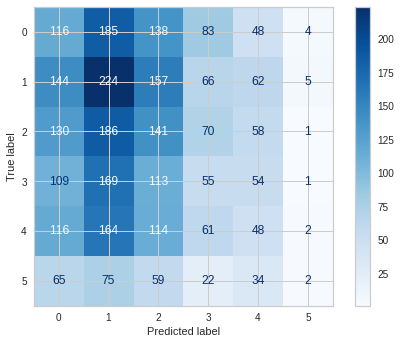

In [181]:
disp = plot_confusion_matrix(lr, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

In [182]:

gnb = GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB()

In [183]:
print(gnb.score(x_test,y_test))

0.19149626744563453


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


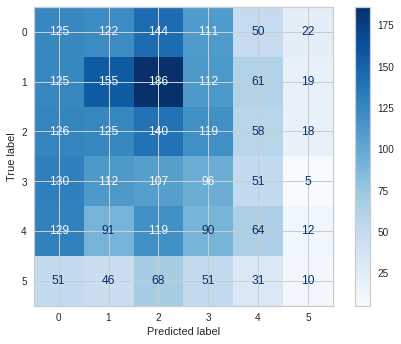

In [185]:
disp = plot_confusion_matrix(gnb, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

In [187]:
rfc = RandomForestClassifier()

In [188]:
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [190]:
print(rfc.score(x_test,y_test))

0.20869847452125934


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


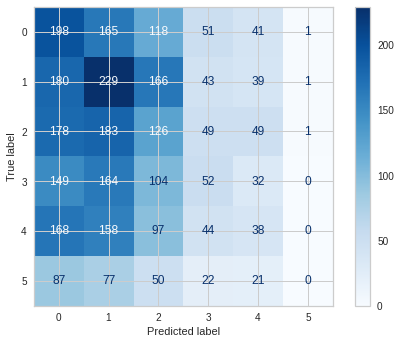

In [191]:
disp = plot_confusion_matrix(rfc, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

In [192]:
svm = SVC(gamma = 'auto')
svm.fit(x_train,y_train)

SVC(gamma='auto')

In [193]:
print(svm.score(x_test,y_test))

0.19571567672833495


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


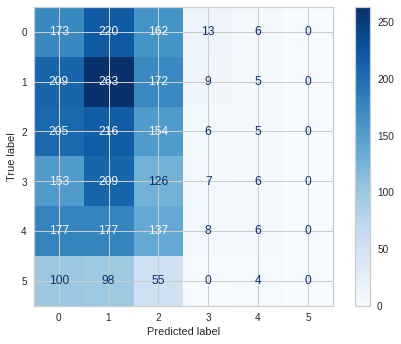

In [194]:
disp = plot_confusion_matrix(svm, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

In [69]:
X.shape

(10269, 100)

In [172]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Flatten

In [208]:

lstm_model = Sequential()
lstm_model.add(LSTM(100,input_shape = (100,1) , return_sequences = True))

lstm_model.add(Dense(50, activation = 'ReLU'))
lstm_model.add(Dense(1, activation = 'sigmoid'))
#model.add(TimeDistributed(Dense(6, activation = 'sigmoid')))
lstm_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics = [tf.metrics.SparseCategoricalAccuracy()]
    )

In [209]:
history = lstm_model.fit(x_train,y_train,validation_data = (x_test,y_test), epochs = 5)

Epoch 1/5
225/225 [==============================] - 28s 111ms/step - loss: 4.4513 - sparse_categorical_accuracy: 0.1277 - val_loss: 4.1933 - val_sparse_categorical_accuracy: 0.1814
Epoch 2/5
225/225 [==============================] - 25s 110ms/step - loss: 4.1580 - sparse_categorical_accuracy: 0.1935 - val_loss: 4.1254 - val_sparse_categorical_accuracy: 0.1808
Epoch 3/5
225/225 [==============================] - 27s 121ms/step - loss: 4.0882 - sparse_categorical_accuracy: 0.1650 - val_loss: 4.0419 - val_sparse_categorical_accuracy: 0.1493
Epoch 4/5
225/225 [==============================] - 20s 90ms/step - loss: 3.9864 - sparse_categorical_accuracy: 0.1343 - val_loss: 3.9212 - val_sparse_categorical_accuracy: 0.1194
Epoch 5/5
225/225 [==============================] - 26s 114ms/step - loss: 3.8684 - sparse_categorical_accuracy: 0.1273 - val_loss: 3.8198 - val_sparse_categorical_accuracy: 0.1376


In [212]:
lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100, 100)          40800     
                                                                 
 dense_39 (Dense)            (None, 100, 50)           5050      
                                                                 
 dense_40 (Dense)            (None, 100, 1)            51        
                                                                 
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


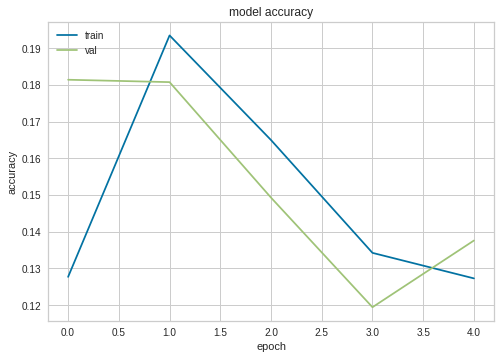

In [213]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [214]:
lstm_model_architecture = lstm_model.to_json()
lstm_model.save_weights('lstm_model-weights.h5')

In [216]:
lstm_model = model_from_json(lstm_model_architecture)
lstm_model.load_weights('lstm_model-weights.h5')

In [143]:
#CNN
x_train_reshape = x_train[..., None]
x_test_reshape = x_test[..., None]

In [151]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(100, 3, activation = 'relu' ))
cnn_model.add(tf.keras.layers.MaxPool1D())
cnn_model.add(tf.keras.layers.Conv1D(50, 3, activation = 'relu' ))
cnn_model.add(tf.keras.layers.MaxPool1D())
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(250, activation = 'relu'))
cnn_model.add(tf.keras.layers.Dense(100, activation = 'relu'))
cnn_model.add(tf.keras.layers.Dense(6, activation = 'sigmoid'))

In [152]:

cnn_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  metrics = tf.metrics.SparseCategoricalAccuracy())

In [218]:
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 98, 100)           400       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 49, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 47, 50)            15050     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 23, 50)           0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1150)              0         
                                                                 
 dense_34 (Dense)            (None, 250)             

In [153]:
history = cnn_model.fit(x_train_reshape,y_train,validation_data = (x_test_reshape,y_test), callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_sparse_categorical_accuracy', mode = 'max', verbose = 1), epochs = 100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


225/225 [==============================] - 6s 23ms/step - loss: 1.7623 - sparse_categorical_accuracy: 0.2074 - val_loss: 1.7577 - val_sparse_categorical_accuracy: 0.2055
Epoch 2/100
225/225 [==============================] - 5s 22ms/step - loss: 1.7556 - sparse_categorical_accuracy: 0.2112 - val_loss: 1.7577 - val_sparse_categorical_accuracy: 0.2119
Epoch 2: early stopping


In [154]:
cnn_model_architecture = cnn_model.to_json()
cnn_model.save_weights('cnn_model-weights.h5')

In [155]:
cnn_model = model_from_json(cnn_model_architecture)
cnn_model.load_weights('cnn_model-weights.h5')

In [156]:
y_pred_cnn = cnn_model.predict(x_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis = 1)

In [157]:
print(accuracy_score(y_test, y_pred_cnn))

0.21194417396949042


In [165]:
print(confusion_matrix(y_target = y_test, y_predicted = y_pred_cnn))

[[184 421   8   0   0   0]
 [150 466   7   0   0   0]
 [163 410   3   0   0   0]
 [148 371   4   0   0   0]
 [133 364   1   0   0   0]
 [ 67 179   2   0   0   0]]


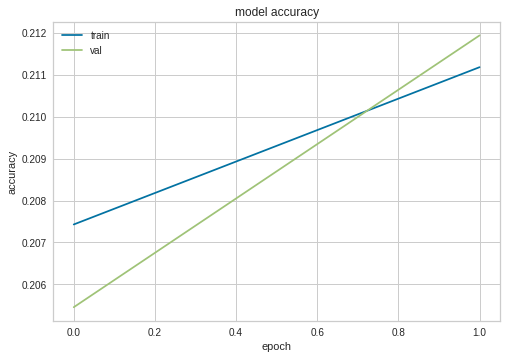

In [171]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [158]:
print(classification_report(y_test,y_pred_cnn))

              precision    recall  f1-score   support

           0       0.22      0.30      0.25       613
           1       0.21      0.75      0.33       623
           2       0.12      0.01      0.01       576
           3       0.00      0.00      0.00       523
           4       0.00      0.00      0.00       498
           5       0.00      0.00      0.00       248

    accuracy                           0.21      3081
   macro avg       0.09      0.18      0.10      3081
weighted avg       0.11      0.21      0.12      3081



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IndexError: ignored

In [16]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [17]:
def preprocess_function(dataset_train):
    return tokenizer(dataset_train["statement"], truncation=True)

In [18]:
dataset_tokenized = dataset.map(preprocess_function,batched = True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [19]:
data_collector = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [20]:
tf_train_set = dataset_tokenized['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols = ['label'],
    shuffle = True,
    batch_size = 16,
    collate_fn = data_collector

)
tf_validate_set = dataset_tokenized['validation'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols = ['label'],
    shuffle = False,
    batch_size = 16,
    collate_fn = data_collector
)

tf_test_set = dataset_tokenized['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols = ['label'],
    shuffle = False,
    batch_size = 16,
    collate_fn = data_collector
)

In [219]:
model2 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_133', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [220]:
model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

In [ ]:
history = model2.fit(tf_train_set, validation_data = tf_validate_set, epochs = 1)

641/641 [==============================] - ETA: 0s - loss: 1.7228 - sparse_categorical_accuracy: 0.2346

In [206]:
y_pred = model2.predict(tf_test_set)['logits']

ValueError: ignored

In [30]:
y_pred = np.argmax(y_pred,axis = 1)

In [33]:
print(accuracy_score(dataset_test['label'],y_pred))

0.26890101325019483


In [35]:
print(classification_report(dataset_test['label'],y_pred))

              precision    recall  f1-score   support

           0       0.28      0.48      0.36       250
           1       0.25      0.27      0.26       267
           2       0.29      0.42      0.34       249
           3       0.67      0.01      0.02       211
           4       0.27      0.14      0.18       214
           5       0.16      0.15      0.16        92

    accuracy                           0.27      1283
   macro avg       0.32      0.25      0.22      1283
weighted avg       0.33      0.27      0.24      1283



In [7]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

In [202]:
#model2_architecture = model2.to_json()
model2.save('distilbert-base-uncased-weights.tf')

INFO:tensorflow:Assets written to: distilbert-base-uncased-weights.tf/assets


INFO:tensorflow:Assets written to: distilbert-base-uncased-weights.tf/assets


In [205]:
#model2 = model_from_json(model2_architecture)
model2 = tf.keras.models.load_model('distilbert-base-uncased-weights.tf')

In [21]:
model3 = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

In [24]:
history = model3.fit(tf_train_set, validation_data = tf_validate_set, epochs = 2)

641/641 [==============================] - 4798s 7s/step - loss: 1.7324 - sparse_categorical_accuracy: 0.2273 - val_loss: 1.6976 - val_sparse_categorical_accuracy: 0.2578


In [46]:
history.history

{'loss': [1.732384204864502],
 'sparse_categorical_accuracy': [0.2272815853357315],
 'val_loss': [1.697574257850647],
 'val_sparse_categorical_accuracy': [0.25778815150260925]}

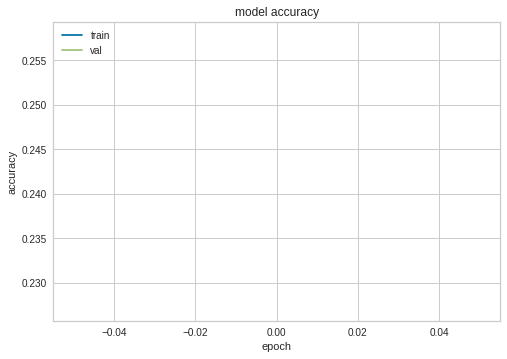

In [29]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
model3.save('bert-base-uncased')

INFO:tensorflow:Assets written to: bert-base-uncased/assets


INFO:tensorflow:Assets written to: bert-base-uncased/assets


In [31]:
model3 = keras.models.load_model('/content/drive/MyDrive/bert-base-uncased')

KeyboardInterrupt: ignored

In [32]:
y_pred = model3.predict(tf_test_set)['logits']

In [33]:
y_pred = np.argmax(y_pred, axis = 1)

In [34]:
print(accuracy_score(dataset_test['label'],y_pred))

0.24629773967264224


In [35]:
print(classification_report(dataset_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.28      0.36      0.32       250
           1       0.03      0.00      0.01       267
           2       0.28      0.47      0.35       249
           3       0.45      0.02      0.05       211
           4       0.20      0.47      0.28       214
           5       0.00      0.00      0.00        92

    accuracy                           0.25      1283
   macro avg       0.21      0.22      0.17      1283
weighted avg       0.23      0.25      0.19      1283



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


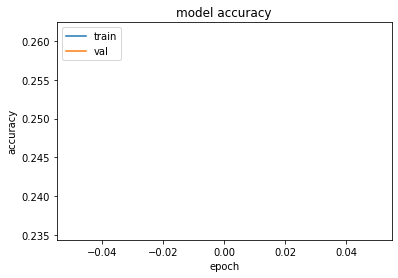

In [42]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
print(history)

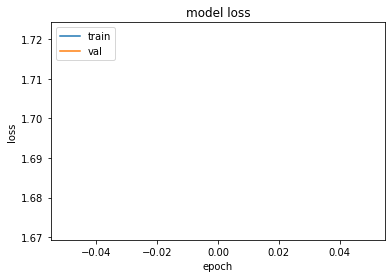

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
model4 = TFAutoModelForSequenceClassification.from_pretrained('roberta-base',num_labels = 6)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model4.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

In [38]:
model4.fit(tf_train_set, validation_data = tf_validate_set, epochs = 1)

641/641 [==============================] - 4864s 8s/step - loss: 1.7664 - sparse_categorical_accuracy: 0.1944 - val_loss: 1.7649 - val_sparse_categorical_accuracy: 0.1955


In [39]:
model4.save('roberta-base')

INFO:tensorflow:Assets written to: roberta-base/assets


INFO:tensorflow:Assets written to: roberta-base/assets


In [80]:
model4 = keras.models.load_model('/content/drive/MyDrive/roberta-base')

In [40]:
model4.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 595206    
 ficationHead)                                                   
                                                                 
Total params: 124,650,246
Trainable params: 124,650,246
Non-trainable params: 0
_________________________________________________________________


In [41]:
y_pred = model4.predict(tf_test_set)['logits']
y_pred = np.argmax(y_pred,axis = 1)

In [42]:
print(accuracy_score(dataset_test['label'], y_pred))

0.1940763834762276


In [43]:
print(classification_report(dataset_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.00      0.00      0.00       267
           2       0.19      1.00      0.33       249
           3       0.00      0.00      0.00       211
           4       0.00      0.00      0.00       214
           5       0.00      0.00      0.00        92

    accuracy                           0.19      1283
   macro avg       0.03      0.17      0.05      1283
weighted avg       0.04      0.19      0.06      1283



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


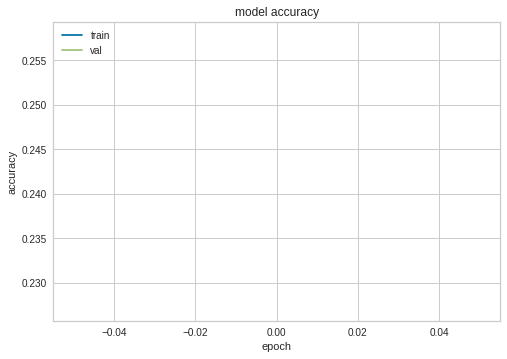

In [44]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()